In [1]:
import sys
sys.path.append('/cluster/sj1')
sys.path.append('/cluster/sj1/bb_opt/src')

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from collections import namedtuple
import torch.distributions as tdist
import bb_opt.src.reparam_trainer as reparam
import numpy as np
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import bb_opt.src.dna_bopt as dbopt
import bayesian_opt as bopt
from gpu_utils.utils import gpu_init
from tqdm import tnrange
import pandas as pd
import copy
from bb_opt.src.utils import train_val_test_split
from sklearn.model_selection import train_test_split
import utils
import gc

gpu_id = gpu_init(best_gpu_metric="mem")
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

Running on GPU 1


In [436]:
Params = namedtuple('params', [
    'output_dist_std', 
    'output_dist_fn', 
    'prior_mean',
    'prior_std',
    'num_epochs',
    'device',
    'exp_noise_samples',
    'train_lr',
    
    'num_train_latent_samples',
    'num_latent_vars',
    'train_batch_size', 
    'hsic_train_lambda',
    
    'ack_batch_size',
    'ack_lr',
    'num_queries',
    'batch_opt_lr',
    'batch_opt_num_iter',
    'input_opt_lr',
    'mves_kernel_fn',
    'input_opt_num_iter',
    'ack_num_model_samples',
    'ack_num_pdts_points',
    'hsic_diversity_lambda',
    'mves_compute_batch_size',
    
    'retrain_num_epochs',
    'retrain_batch_size',
    'retrain_lr',
    'hsic_retrain_lambda',
    'num_retrain_latent_samples',
    
    'score_fn', # order is logp, qed, sas
    
])
params = Params(
    output_dist_std=1.,
    output_dist_fn=tdist.Normal, 
    exp_noise_samples=2, 
    prior_mean=0.,
    prior_std=3.,
    device='cuda',
    num_epochs=500,
    train_lr=1e-4,
    
    train_batch_size=10,
    num_latent_vars=15,
    num_train_latent_samples=20,
    hsic_train_lambda=20.,
    
    ack_batch_size=50,
    ack_lr=1e-3,
    num_queries=1,
    batch_opt_lr=1e-3,
    batch_opt_num_iter=10000,
    input_opt_lr=1e-3,
    mves_kernel_fn='mixrq_kernels',
    input_opt_num_iter=2500,
    ack_num_model_samples=100,
    ack_num_pdts_points=40,
    hsic_diversity_lambda=1,
    mves_compute_batch_size=4000,
    
    retrain_num_epochs=500,
    retrain_batch_size=10,
    retrain_lr=1e-4,
    hsic_retrain_lambda=20.,
    num_retrain_latent_samples=20,
    
    score_fn=lambda x : 5*x[1]-x[2],
)

In [333]:
n_train = 50

project = "dna_binding"
dataset = "crx_ref_r1"

root = "/cluster/sj1/bb_opt/"
data_dir = root+"data/"+project+"/"+dataset+"/"
inputs = np.load(data_dir+"inputs.npy")
labels = np.load(data_dir+"labels.npy")


exclude_top = 0.1

idx = np.arange(labels.shape[0])

labels_sort_idx = labels.argsort()
sort_idx2 = labels_sort_idx[:-int(labels.shape[0]*exclude_top)]
idx = idx[sort_idx2]

train_idx, _, _ = train_val_test_split(idx, split=[n_train, 0])
train_idx2, _, test_idx2 = train_val_test_split(n_train, split=[0.9, 0])

test_idx = train_idx[test_idx2]
train_idx = train_idx[train_idx2]

train_inputs = inputs[train_idx]
train_labels = labels[train_idx]

val_inputs = inputs[test_idx]
val_labels = labels[test_idx]


#train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=n_train, random_state=521)
#train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, train_size=0.9, random_state=521)

In [334]:
labels_sort_idx = labels.argsort()
top_point_idx = labels_sort_idx[-1]
top_one_percent_idx = labels_sort_idx[-int(labels.shape[0]*0.01):]
top_one_percent_sum = labels[top_one_percent_idx].sum()

In [335]:
train_label_mean = train_labels.mean()
train_label_std = train_labels.std()

train_labels = (train_labels - train_label_mean) / train_label_std
val_labels = (val_labels - train_label_mean) / train_label_std

In [404]:
train_X = torch.FloatTensor(train_inputs).to(device)
train_Y = torch.FloatTensor(train_labels).to(device)
val_X = torch.FloatTensor(val_inputs).to(device)
val_Y = torch.FloatTensor(val_labels).to(device)

In [8]:
import bb_opt.src.dna_bopt as dbopt

In [478]:
model, qz, e_dist = dbopt.get_model_nn(params, inputs.shape[1], params.num_latent_vars, params.prior_std)

In [479]:
train_losses = []
train_kl_losses = []
train_hsic_losses = []
val_losses = []

train_corrs = []
val_corrs = []

In [244]:
import bb_opt.src.dna_bopt as dbopt

In [480]:
data = [train_X, train_Y, val_X, val_Y]
logging = dbopt.train(params, params.train_batch_size, params.train_lr, params.num_epochs, params.hsic_train_lambda, params.num_train_latent_samples, data, model, qz, e_dist)

training:
45 samples
10 batch_size
4 num_batches
500 num_epochs


A Jupyter Widget

In [408]:
i_losses, i_kl_losses, i_hsic_losses, i_corrs, i_val_corrs = logging

train_losses += i_losses
train_kl_losses += i_kl_losses
train_hsic_losses += i_hsic_losses

train_corrs += i_corrs
val_corrs += i_val_corrs

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


train_corrcoef: 0.38857324006812344
val_corrcoef: 0.6813066725200181


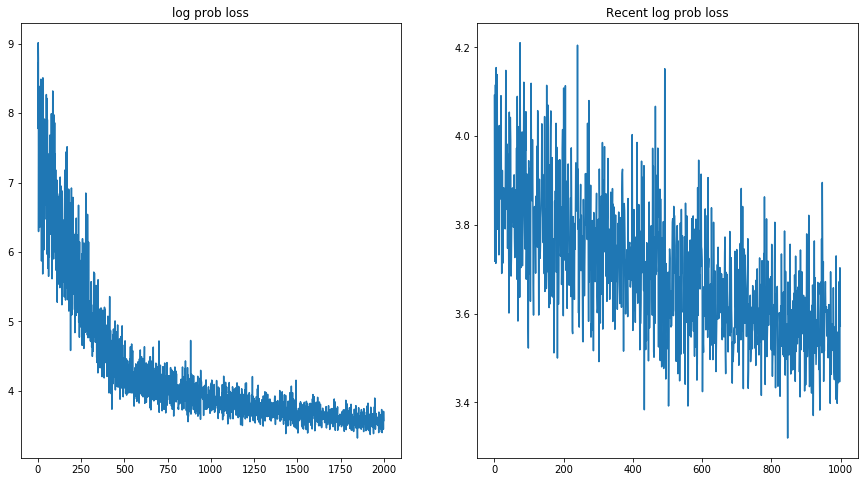

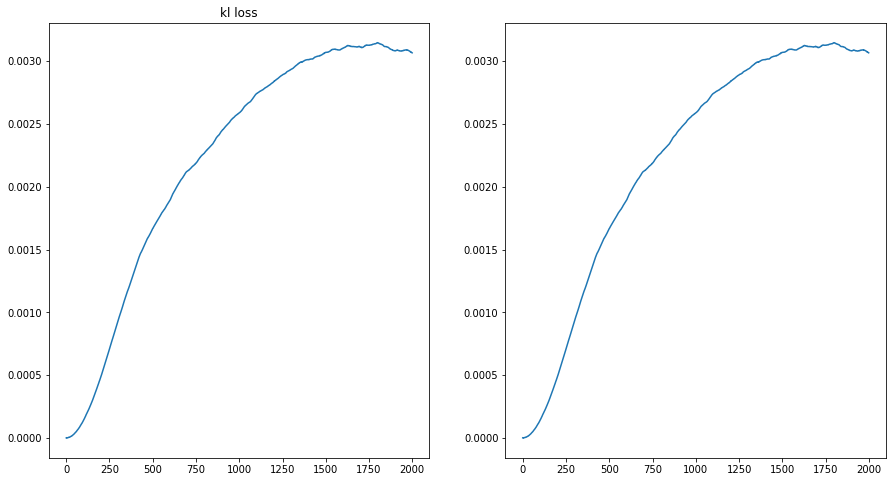

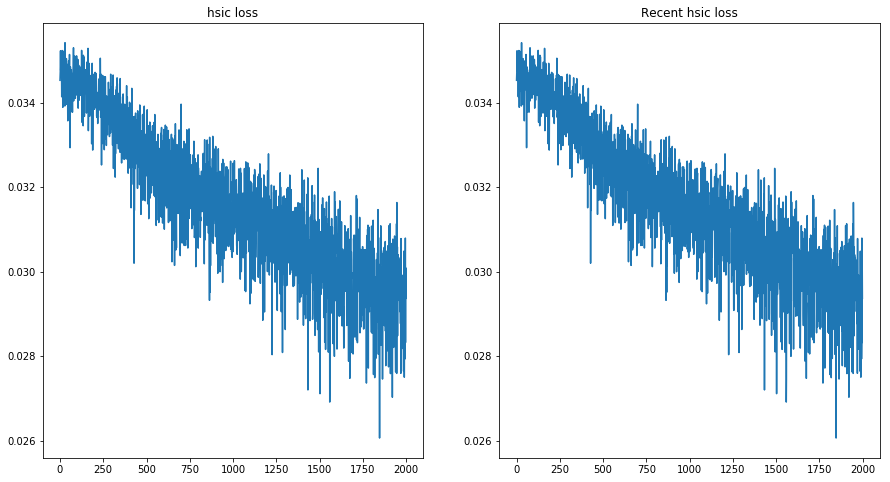

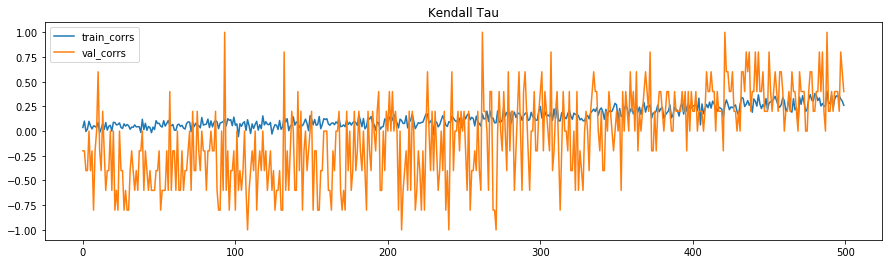

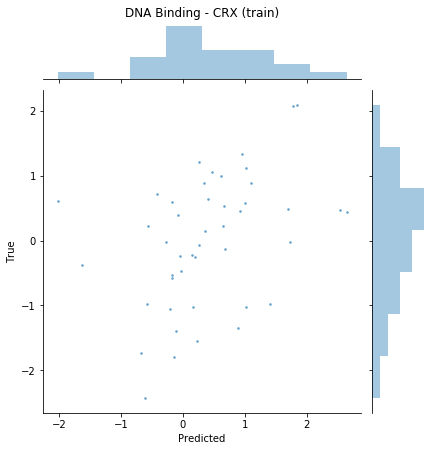

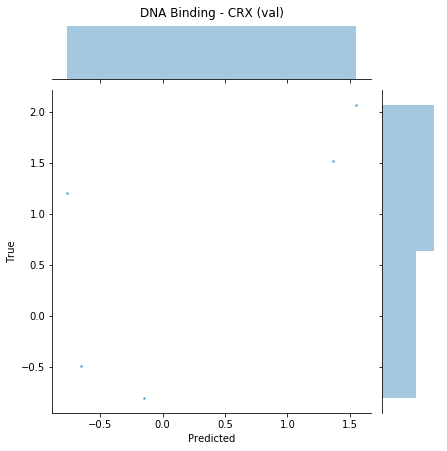

In [409]:
plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.plot(train_losses)
plt.title("log prob loss")

plt.subplot(122)
plt.plot(train_losses[-1000:])
plt.title("Recent log prob loss")

plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.plot(train_kl_losses)
plt.title("kl loss")

plt.subplot(122)
plt.plot(train_kl_losses[-3000:])

plt.figure(figsize=(15, 8))
plt.subplot(121)

plt.plot(train_hsic_losses)
plt.title("hsic loss")

plt.subplot(122)
plt.plot(train_hsic_losses[-3000:])

plt.title("Recent hsic loss")

plt.figure(figsize=(15, 4))

plt.plot(train_corrs, label="train_corrs")
plt.plot(val_corrs, label="val_corrs")
plt.legend()
plt.title("Kendall Tau");

title = "DNA Binding - CRX"
train_title = title + " (train)"
val_title = title + " (val)"

e = reparam.generate_prior_samples(params.num_train_latent_samples, e_dist)
if n_train > 1:
    preds = reparam.predict(train_X, model, qz, e).mean(1).view(-1)
    utils.jointplot(preds, train_labels, train_title)
    print('train_corrcoef:', np.corrcoef(preds, train_labels)[0, 1])

preds = reparam.predict(val_X, model, qz, e).mean(1).view(-1)
utils.jointplot(preds, val_labels, val_title)
print('val_corrcoef:', np.corrcoef(preds, val_labels)[0, 1])

In [452]:
X = torch.tensor(inputs, device=device)
Y = torch.tensor(labels, device=device)

In [350]:
e = reparam.generate_prior_samples(100, e_dist)
model_ensemble = reparam.generate_ensemble_from_stochastic_net(model, qz, e)
preds = model_ensemble(X, expansion_size=0, batch_size=1000, output_device='cpu') # (num_candidate_points, num_samples)
preds = preds.transpose(0, 1)

In [16]:
import bayesian_opt as bopt
import dna_bopt as dbopt

In [17]:
e = reparam.generate_prior_samples(params.ack_num_model_samples, e_dist)

In [18]:
X.shape

torch.Size([32896, 32])

In [20]:
import reparam_trainer as reparam

In [351]:
ei = preds.mean(dim=0).view(-1).cpu().numpy()
ei_sortidx = np.argsort(ei)

In [352]:
np.sort(labels[ei_sortidx[-50:]])

array([ 74956.16,  84109.69,  84869.02,  84973.03,  85398.34,  85785.46,
        86391.28,  88453.27,  88869.78,  89187.67,  89284.74,  89619.3 ,
        90741.99,  90924.42,  91292.91,  92382.01,  92862.93,  93496.2 ,
        93722.33,  94252.47,  94664.03,  94668.19,  94972.88,  95146.59,
        95641.95,  96618.67,  96698.51,  97089.3 ,  97168.28,  97283.07,
        98279.72, 101173.2 , 101477.7 , 101703.8 , 101934.34, 104140.98,
       104171.53, 104580.14, 105509.37, 108383.03, 109010.52, 110040.34,
       110154.38, 112433.51, 114383.93, 115328.18, 115614.03, 118288.89,
       127364.43, 187777.16], dtype=float32)

In [476]:
model_ei = copy.deepcopy(model)
qz_ei = copy.deepcopy(qz)
train_X_ei = torch.FloatTensor(train_inputs).to(device)
train_Y_ei = torch.FloatTensor(train_labels).to(device)
val_X = torch.FloatTensor(val_inputs).to(device)
val_Y = torch.FloatTensor(val_labels).to(device)

In [477]:
skip_idx_ei = set(train_idx)
ack_all_ei = set()
for ack_iter in range(10):
    model_ensemble = reparam.generate_ensemble_from_stochastic_net(model_ei, qz_ei, e)
    preds = model_ensemble(X, expansion_size=0, batch_size=1000, output_device='cpu') # (num_candidate_points, num_samples)
    preds = preds.transpose(0, 1)
    print("done predictions")
    
    ei = preds.mean(dim=0).view(-1).cpu().numpy()
    ei_sortidx = np.argsort(ei)
    ei_idx = []
    for idx in ei_sortidx[::-1]:
        if idx not in skip_idx_ei:
            ei_idx += [idx]
        if len(ei_idx) >= params.ack_batch_size:
            break
    ack_all_ei.update(ei_idx)
    skip_idx_ei.update(ei_idx)
    ei_idx = torch.LongTensor(ei_idx).to(params.device)
    
    ack_ei = X[ei_idx]
    ack_ei_vals = (Y[ei_idx]-float(train_label_mean))/float(train_label_std)
    
    train_X_ei = torch.cat([train_X_ei, ack_ei], dim=0)
    train_Y_ei = torch.cat([train_Y_ei, ack_ei_vals], dim=0)
    data = [train_X_ei, train_Y_ei, val_X, val_Y]
    logging = dbopt.train(
        params, 
        params.retrain_batch_size, 
        params.retrain_lr,
        params.retrain_num_epochs, 
        params.hsic_retrain_lambda, 
        params.num_retrain_latent_samples, 
        data, 
        model_ei, 
        qz_ei, 
        e_dist)
    
    e = reparam.generate_prior_samples(100, e_dist)
    model_ensemble = reparam.generate_ensemble_from_stochastic_net(model_ei, qz_ei, e)
    preds = model_ensemble(X, expansion_size=0, batch_size=1000, output_device='cpu') # (num_candidate_points, num_samples)
    preds = preds.transpose(0, 1)
    ei = preds.mean(dim=0).view(-1).cpu().numpy()
    ei_sortidx = np.argsort(ei)[-50:]
    ack = list(ack_all_ei.union(list(ei_sortidx)))
    best_10 = np.sort(labels[ack])[-10:]
    print(len(ack), best_10.mean(), best_10.max())

done predictions
training:
95 samples
10 batch_size
9 num_batches
500 num_epochs


A Jupyter Widget

97 138684.45 169435.62
done predictions
training:
145 samples
10 batch_size
14 num_batches
500 num_epochs


A Jupyter Widget

123 161179.05 190855.28
done predictions
training:
195 samples
10 batch_size
19 num_batches
500 num_epochs


A Jupyter Widget

183 263569.8 308955.4
done predictions
training:
245 samples
10 batch_size
24 num_batches
500 num_epochs


A Jupyter Widget

231 283959.06 328504.1
done predictions
training:
295 samples
10 batch_size
29 num_batches
500 num_epochs


A Jupyter Widget

275 283959.06 328504.1
done predictions
training:
345 samples
10 batch_size
34 num_batches
500 num_epochs


A Jupyter Widget

302 283959.06 328504.1
done predictions
training:
395 samples
10 batch_size
39 num_batches
500 num_epochs


A Jupyter Widget

350 283959.06 328504.1
done predictions
training:
445 samples
10 batch_size
44 num_batches
500 num_epochs


A Jupyter Widget

400 283959.06 328504.1
done predictions
training:
495 samples
10 batch_size
49 num_batches
500 num_epochs


A Jupyter Widget

450 283959.06 328504.1
done predictions
training:
545 samples
10 batch_size
54 num_batches
500 num_epochs


A Jupyter Widget

500 283959.06 328504.1


In [462]:
del best_hsic
del skip_idx

In [327]:
print(gc.collect())
torch.cuda.empty_cache()

90


In [328]:
import bayesian_opt as bopt

In [466]:
model_mves = copy.deepcopy(model)
qz_mves = copy.deepcopy(qz)
train_X_mves = torch.FloatTensor(train_inputs).to(device)
train_Y_mves = torch.FloatTensor(train_labels).to(device)
val_X = torch.FloatTensor(val_inputs).to(device)
val_Y = torch.FloatTensor(val_labels).to(device)

In [425]:
sorted_preds_idx.shape

(100, 32896)

In [442]:
labels[np.unique(sorted_preds_idx[:, -10:])][-50:]

array([114026.54,  94414.95, 145506.89,  99064.45, 119892.41, 113149.59,
       138655.98,  87930.34,  99110.81, 105547.33,  76534.97, 106764.05,
       105005.75,  84892.67,  82316.89, 104177.87,  65410.51, 101275.68,
       112422.12, 185655.56,  83933.9 , 147728.12,  94379.33, 121109.06,
       122566.28,  91548.51,  87236.11, 110037.87, 149715.53,  88602.56,
        91237.89, 110543.42,  96232.07,  90799.12, 116262.8 , 126322.98,
       107818.98, 116279.14, 101389.42,  98943.21, 110761.47, 115616.19,
        86374.21,  87834.25,  97048.58, 100870.67,  97649.25,  98379.15,
        95025.68, 108020.4 ], dtype=float32)

In [ ]:
skip_idx_mves = set(train_idx)
ack_all_mves = set()
for ack_iter in range(10):
    model_ensemble = reparam.generate_ensemble_from_stochastic_net(model_mves, qz_mves, e)
    preds = model_ensemble(X, expansion_size=0, batch_size=1000, output_device='cpu') # (num_candidate_points, num_samples)
    preds = preds.transpose(0, 1)
    print("done predictions")
    
    top_k = 20
    
    sorted_preds_idx = []
    for i in range(preds.shape[0]):
        sorted_preds_idx += [np.argsort(preds[i].numpy())]
    sorted_preds_idx = np.array(sorted_preds_idx)
    print('diversity:', len(set(sorted_preds_idx[:, -top_k:].flatten())))
    
    sorted_preds = torch.sort(preds, dim=1)[0]    
    #best_pred = preds.max(dim=1)[0].view(-1)
    best_pred = sorted_preds[:, -top_k:]
    
    mves_compute_batch_size = params.mves_compute_batch_size
    mves_compute_batch_size = 4000
    ack_batch_size=50
    mves_idx, best_hsic = bopt.acquire_batch_mves_sid(params, best_pred, preds, skip_idx_mves, mves_compute_batch_size, ack_batch_size, true_labels=labels)
    print('best_hsic:', best_hsic)
    skip_idx_mves.update(mves_idx)
    ack_all_mves.update(mves_idx)
    mves_idx = torch.tensor(list(mves_idx)).to(params.device)
    
    ack_mves = X[mves_idx]
    ack_mves_vals = (Y[mves_idx]-float(train_label_mean))/float(train_label_std)
    
    train_X_mves = torch.cat([train_X_mves, ack_mves], dim=0)
    train_Y_mves = torch.cat([train_Y_mves, ack_mves_vals], dim=0)
    data = [train_X_mves, train_Y_mves, val_X, val_Y]
    logging = dbopt.train(
        params, 
        params.retrain_batch_size, 
        params.retrain_lr, 
        params.retrain_num_epochs, 
        params.hsic_retrain_lambda, 
        params.num_retrain_latent_samples, 
        data, 
        model_mves, 
        qz_mves, 
        e_dist)
    
    e = reparam.generate_prior_samples(100, e_dist)
    model_ensemble = reparam.generate_ensemble_from_stochastic_net(model_mves, qz_mves, e)
    preds = model_ensemble(X, expansion_size=0, batch_size=1000, output_device='cpu') # (num_candidate_points, num_samples)
    preds = preds.transpose(0, 1)
    ei = preds.mean(dim=0).view(-1).cpu().numpy()
    ei_sortidx = np.argsort(ei)[-50:]
    ack = list(ack_all_mves.union(list(ei_sortidx)))
    best_10 = np.sort(labels[ack])[-10:]
    print(len(ack), best_10.mean(), best_10.max())
    best_pdts_10 = labels[np.unique(sorted_preds_idx[:, -top_k:])][-10:]
    print(best_pdts_10.mean(), best_pdts_10.max())

done predictions
diversity: 211
10 [119075.9, 119744.95, 120366.77, 147103.27, 177830.72]
20 [120366.77, 122682.52, 142274.19, 147103.27, 177830.72]
30 [122682.52, 126256.05, 142274.19, 147103.27, 177830.72]
40 [142274.19, 144859.81, 147103.27, 177830.72, 261299.78]
best_hsic: 0.008792063221335411
training:
295 samples
10 batch_size
29 num_batches
500 num_epochs


A Jupyter Widget

284 237875.83 328993.28
116634.02 141162.53
done predictions
diversity: 120
10 [139783.73, 163466.75, 167700.33, 202365.8, 311019.88]
20 [184208.62, 184620.44, 202365.8, 208545.97, 311019.88]
30 [184620.44, 186071.28, 202365.8, 208545.97, 311019.88]
40 [184620.44, 186071.28, 202365.8, 208545.97, 311019.88]
best_hsic: 0.008584907278418541
training:
345 samples
10 batch_size
34 num_batches
500 num_epochs


A Jupyter Widget

In [252]:
preds2 = preds.cpu().numpy()

In [260]:
sorted_preds = []
for i in range(preds2.shape[0]):
    sorted_preds += [np.argsort(preds2[i])]
sorted_preds = np.array(sorted_preds)

In [261]:
temp = preds2.argmax(axis=0)
temp2 = sorted_preds[:, -10:].flatten()

In [262]:
print(len(set(temp)), len(set(temp2)))

23 473


In [255]:
pd.Series(temp).value_counts()

12    8752
4     5690
52    5410
92    4580
81    2901
2     1755
48    1552
63    1334
99     591
68      66
31      58
21      56
71      39
28      24
58      20
74      20
22      15
62      13
30       6
15       6
10       3
29       3
78       2
dtype: int64

In [ ]:
for ack_iter in range(10):
    preds = model_ensemble(X, resize_at_end=True) # (num_candidate_points, num_samples)
    preds = preds.tranpose(0, 1)
    
    max_pred_idx = preds.argmax(dim=1).view(-1)
    max_pred = preds.max(dim=1).view(-1)